<a href="https://colab.research.google.com/github/GIBD/GIBDnews/blob/master/GIBDnews_3_Topic_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **GIBDnews**
**Aplicación de Técnicas de Minería de Textos a noticias** 

**Parte 3**


---

# **Topic Modeling**
---

**Carga de librerías**

---

In [0]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords
import string
import matplotlib.pyplot as plt
import gensim
import numpy as np
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.models.wrappers import LdaMallet
from gensim.models.phrases import Phrases, Phraser
from gensim.corpora import Dictionary

---

**Conexión a Google Drive para carga de datos**

---

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


---

**Configuración de directorio de trabajo**

---

In [0]:
import os
os.chdir("/content/drive/My Drive/Colab Notebooks/GIBDnews/data")

---

**Importación de archivo de noticias (TMnews.csv)**

---

In [4]:
import pandas as pd 
df_news = pd.read_csv('GIBDnews-abril.csv')
df_news

,news_paper,category,date,titleandbody
0,clarin,deportes,2020-04-11,El “Pablo Vico” de España: tiene 83 años y pas...
1,clarin,deportes,2020-04-11,Adelantan que en Barcelona se habrían pagado s...
2,clarin,deportes,2020-04-11,"Jana Pittman, la campeona mundial que lucha en..."
3,clarin,deportes,2020-04-11,Coronavirus: la OMS pidió que paren el fútbol ...
4,clarin,deportes,2020-04-11,"El Araña Amuchástegui, el crack que rechazó un..."
...,...,...,...,...
3126,lanacion,tecnologia,2020-04-22,Agenda Vida Digital // ILVEM.\r\n\r\n Brindará...
3127,lanacion,tecnologia,2020-04-22,El otoño de los museos // Siempre es una buena...
3128,lanacion,tecnologia,2020-04-22,Las nuevas tecnologías salen a dar batalla con...
3129,lanacion,tecnologia,2020-04-22,#LNteacompaña: fotos de Buenos Aires vacía par...


In [5]:
df_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3131 entries, 0 to 3130
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   news_paper    3131 non-null   object
 1   category      3131 non-null   object
 2   date          3131 non-null   object
 3   titleandbody  3131 non-null   object
dtypes: object(4)
memory usage: 98.0+ KB


---

**Preprocesamiento de Datos**

Se define la función *cleaner* para limpiar texto en español, eliminar caracteres no alfanuméricos, duplicados y dígitos.

---

In [0]:
def cleaner(word):
  word = re.sub(r'((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*', '', word, flags=re.MULTILINE)
  word = re.sub(r'(?::|;|=)(?:-)?(?:\)|\(|D|P)', "", word)
  word = re.sub(r'\#\.', '', word)
  word = re.sub(r'\n', '', word)
  word = re.sub(r',', '', word)
  word = re.sub(r'\-', ' ', word)
  word = re.sub(r'\.{3}', ' ', word)
  word = re.sub(r'a{2,}', 'a', word)
  word = re.sub(r'é{2,}', 'é', word)
  word = re.sub(r'i{2,}', 'i', word) 
  word = re.sub(r'á', 'a', word)
  word = re.sub(r'é', 'e', word)
  word = re.sub(r'í', 'i', word)
  word = re.sub(r'ó', 'o', word)
  word = re.sub(r'ú', 'u', word)  
  word = re.sub('[^a-zA-Z]', ' ', word)
  list_word_clean = []
  # Se tokeniza el texto y eliminan stop words
  for w1 in word.split(" "):
    if  w1.lower() not in stopwords:
      list_word_clean.append(w1.lower())
  # Se identifican bigramas de caracteres
  bigram_list = bigram[list_word_clean]
  # Se aplica lematización
  out_text = lemmatization(" ".join(bigram_list))
  return out_text

---

Se define la función para seleccionar solo sustantivos, eliminando adverbios, adjetivos, verbos, entre otros, mediante *spacy*

---

In [0]:
def lemmatization(texts, allowed_postags=['NOUN']):
    texts_out = [ token.text for token in nlp(texts) if token.pos_ in 
                 allowed_postags and token.text not in stopwords and len(token.text)>2]
    return texts_out

---

Para emplear *gensim* se requiere una lista de texto. Se prueba la función de conversión .tolist() y se verifica que coincida el resultado con la cantidad de noticias originales.

---

In [8]:
len(df_news.titleandbody.tolist())

3131

---

Se entrena el modelo "Phrases" de gensim con el texto de las noticias y se lo almacena en la variable bigram para que luego sea utilizado en la función cleaner().
El modelo "Phrases" identifica bigramas: pares de palabras que juntas tienen más significado.

---


In [9]:
%%time
bigram = gensim.models.Phrases(df_news.titleandbody.tolist())
#print(list(df_news.titleandbody.str.split(" ")))

CPU times: user 17.1 s, sys: 0 ns, total: 17.1 s
Wall time: 17.1 s


---

Se prueba el modelo entrenado con una noticia.

---


In [10]:
bigram[df_news.titleandbody.tolist()[10].split()]

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['Daniele',
 'De',
 'Rossi:',
 'de',
 'los',
 'elogios',
 'para',
 'Gallardo,',
 'Heinze',
 'y',
 'Crespo',
 'a',
 'la',
 'crítica',
 'al',
 'fútbol',
 'argentino',
 '//',
 'Daniele',
 'De',
 'Rossi',
 'colgó',
 'los',
 'botines,',
 'pero',
 'no',
 'se',
 'alejó',
 'del',
 'mundo',
 'fútbol.',
 'En',
 'medio',
 'de',
 'la',
 'cuarentena',
 'en',
 'Roma,',
 'el',
 'Tano',
 'habló',
 'sobre',
 'diferentes',
 'temas.',
 'Más',
 'allá',
 'de',
 'que',
 'recordó',
 'su',
 'paso',
 'por',
 'Boca',
 'y',
 'de',
 'que',
 'ratificó',
 'sus',
 'ganas',
 'de',
 'convertirse',
 'en',
 'entrenador,',
 'el',
 'italiano',
 'analizó',
 'cómo',
 'es',
 'jugar',
 'es',
 'nuestro',
 'país,',
 'criticó',
 'al',
 'fútbol',
 'argentino',
 'y',
 'sorprendió',
 'a',
 'la',
 'hora',
 'de',
 'poner',
 'como',
 'ejemplo',
 'a',
 'Marcelo',
 'Gallardo<U+200B>.<U+200B>',
 '"En',
 'Argentina',
 'la',
 'experiencia',
 'fue',
 'maravillosa',
 'y',
 'aprendí',
 'mucho',
 'desde',
 'un',
 'punto',
 'de',
 'vista',
 'hu

---

Se importa la librería NLTK y se descargan *stopwords* y el tokenizador *punkt*. Se configura el uso de *stopwords* en español. Se deja comentado para futuras prueba la posibilidad de configurar una *black_list* con palabras que explícitamente se quieren eliminar.

---

In [11]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [0]:
from nltk import word_tokenize
from nltk.corpus import stopwords
stopwords = set(stopwords.words('spanish'))

black_list = ['coronavirus','persona','personas','casos','millones','virus','datos']

additional_stopwords=set(black_list)
stopwords = stopwords.union(additional_stopwords)


In [0]:
stopwords

{'a',
 'al',
 'algo',
 'algunas',
 'algunos',
 'ante',
 'antes',
 'casos',
 'como',
 'con',
 'contra',
 'coronavirus',
 'cual',
 'cuando',
 'de',
 'del',
 'desde',
 'donde',
 'durante',
 'e',
 'el',
 'ella',
 'ellas',
 'ellos',
 'en',
 'entre',
 'era',
 'erais',
 'eran',
 'eras',
 'eres',
 'es',
 'esa',
 'esas',
 'ese',
 'eso',
 'esos',
 'esta',
 'estaba',
 'estabais',
 'estaban',
 'estabas',
 'estad',
 'estada',
 'estadas',
 'estado',
 'estados',
 'estamos',
 'estando',
 'estar',
 'estaremos',
 'estará',
 'estarán',
 'estarás',
 'estaré',
 'estaréis',
 'estaría',
 'estaríais',
 'estaríamos',
 'estarían',
 'estarías',
 'estas',
 'este',
 'estemos',
 'esto',
 'estos',
 'estoy',
 'estuve',
 'estuviera',
 'estuvierais',
 'estuvieran',
 'estuvieras',
 'estuvieron',
 'estuviese',
 'estuvieseis',
 'estuviesen',
 'estuvieses',
 'estuvimos',
 'estuviste',
 'estuvisteis',
 'estuviéramos',
 'estuviésemos',
 'estuvo',
 'está',
 'estábamos',
 'estáis',
 'están',
 'estás',
 'esté',
 'estéis',
 'est

---

Se emplea *spacy* para lematizar palabras en lenguaje español.

---

In [13]:
!python -m spacy download es_core_news_md

     |████████████████████████████████| 78.4MB 1.4MB/s 
  Created wheel for es-core-news-md: filename=es_core_news_md-2.2.5-cp36-none-any.whl size=79649483 sha256=e2f7b9d36cb747498bd33c2bd9a426501a80b7751e65faa754606aa047332a5d
  Stored in directory: /tmp/pip-ephem-wheel-cache-8pu1u580/wheels/b7/bb/a3/29ab5cf80c2c0a8fa0f2af8402fdace3f159e8265f0fdcbcdb
Successfully built es-core-news-md
✔ Download and installation successful
You can now load the model via spacy.load('es_core_news_md')


In [0]:
import spacy
nlp = spacy.load('/usr/local/lib/python3.6/dist-packages/es_core_news_md/es_core_news_md-2.2.5')

---

Se prueba de la función *cleaner*

---

In [0]:
df_news.titleandbody[0]

'El “Pablo Vico” de España: tiene 83 años y pasa la cuarentena en un estadio de fútbol // La cuarentena nos obligó a quedarnos en casa y pasar los días encerrados no es sencillo. Los que viven en departamentos se tienen que conformar con sentarse en el balcón, para hacer ejercicio hay que correr algunos muebles y a esta altura tener al menos un patio es un lujo. Muy distinta es la realidad de Andrés Perales, un jubilado que tiene lugar de sobra y hasta se aburre por contar con tanto espacio libre... Sí, a sus 83 años se encuentra aislado en un lugar para 30.000 personas porque vive en La Rosaleda, el estadio del Málaga. <U+200B>Un caso similar al de Pablo Vico, DT de Brown de Adrogué, que tiene su casa en la cancha del Tricolor del Sur del Gran Buenos Aires y también pasa una peculiar cuarentena obligatoria\xa0ahí nomás del verde césped. ¿Cómo llegó Perales a tener su casa dentro de una cancha de fútbol? Llegó al club en 1966 y desde ese momento se dedicó a ayudar a la institución y no

In [0]:
cleaner(df_news.titleandbody[0])

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['estadio',
 'futbol',
 'quedarnos',
 'casa',
 'departamentos',
 'ejercicio',
 'muebles',
 'altura',
 'patio',
 'realidad',
 'perales',
 'lugar',
 'espacio',
 'lugar',
 'personas',
 'caso',
 'tambien',
 'cuarentena',
 'llego',
 'perales',
 'casa',
 'cancha',
 'futbol',
 'club',
 'momento',
 'chofer',
 'equipo',
 'conserje',
 'casa',
 'numero',
 'paseo',
 'estadio',
 'metros',
 'puerta',
 'nombre',
 'crio',
 'esposa',
 'hijos',
 'hijos',
 'quiebra',
 'cancha',
 'temporada',
 'ingresos',
 'incertidumbre',
 'noches',
 'taxi',
 'dinero',
 'casa',
 'podia',
 'gasoil',
 'autoridades',
 'afectados',
 'parte',
 'riesgo',
 'casa',
 'situacion',
 'lugar',
 'vacio',
 'vacaciones',
 'espacio',
 'punto',
 'cuarentena',
 'lugar',
 'expreso',
 'declaraciones',
 'sitio',
 'club',
 'nombre',
 'foto',
 'prensa',
 'autos',
 'puerta',
 'hinchas',
 'falta',
 'ademas',
 'instalaciones',
 'horas',
 'partidos',
 'entrenamientos',
 'mantenimiento',
 'oficinas',
 'vida',
 'presidentes',
 'equipo',
 'ascenso',
 

---

Se aplica la función *clean* a la columna *titleandbody* del dataframe *df_news* que contiene el título y el cuerpo de todas las noticias

---


In [0]:
df_news['titleandbody2'] = df_news['titleandbody']

In [16]:
%%time
df_news['titleandbody'] = df_news['titleandbody'].apply(cleaner)

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


CPU times: user 3min 8s, sys: 1.96 s, total: 3min 10s
Wall time: 3min 11s


---

En este paso se exporta el dataframe como CSV con la columna *titleandbody* limpia para futuros usos ya que la ejecución *cleaner* demanda mucho tiempo (aprox. 40 minutos)

---

In [0]:
news_Clean = df_news.to_csv (r'/content/drive/My Drive/Colab Notebooks/GIBDnews/data/news_clean.csv', index = None, header=True)

---

Se importa el archivo *news_clean.csv*

---

In [18]:
df_news = pd.read_csv('news_clean.csv')
df_news

,news_paper,category,date,titleandbody,titleandbody2
0,clarin,deportes,2020-04-11,"['estadio', 'futbol', 'quedarnos', 'casa', 'de...",El “Pablo Vico” de España: tiene 83 años y pas...
1,clarin,deportes,2020-04-11,"['empresa', 'jugadores', 'opositores', 'tempor...",Adelantan que en Barcelona se habrían pagado s...
2,clarin,deportes,2020-04-11,"['cara', 'deportistas', 'rol', 'lucha', 'caso'...","Jana Pittman, la campeona mundial que lucha en..."
3,clarin,deportes,2020-04-11,"['futbol', 'futbol', 'resto', 'actividades', '...",Coronavirus: la OMS pidió que paren el fútbol ...
4,clarin,deportes,2020-04-11,"['minuto', 'dilema', 'pagos', 'mundo', 'mote',...","El Araña Amuchástegui, el crack que rechazó un..."
...,...,...,...,...,...
3126,lanacion,tecnologia,2020-04-22,"['herramientas', 'informes', 'marco', 'adultos...",Agenda Vida Digital // ILVEM.\r\n\r\n Brindará...
3127,lanacion,tecnologia,2020-04-22,"['museos', 'idea', 'sociedad', 'titulo', 'soci...",El otoño de los museos // Siempre es una buena...
3128,lanacion,tecnologia,2020-04-22,"['tecnologias', 'batalla', 'investigador', 'ha...",Las nuevas tecnologías salen a dar batalla con...
3129,lanacion,tecnologia,2020-04-22,"['fotos', 'parte', 'dia', 'dia', 'seguidores',...",#LNteacompaña: fotos de Buenos Aires vacía par...


---

En este paso se construyen el *corpus* y el *diccionario* para usar *gensim*. Para la construcción se pasa como parámetro una lista de listas de tokens.

---

In [0]:
from ast import literal_eval

tokens = df_news['titleandbody'].apply(literal_eval)

dictionary = Dictionary(tokens)
dictionary.compactify()

# Filter extremes
dictionary.filter_extremes(no_below=2, no_above=0.97, keep_n=None)
dictionary.compactify()

corpus = [dictionary.doc2bow(literal_eval(text)) for text in df_news['titleandbody']]



---

# **Modelado**

A continuación se realiza la comparación de tres algoritmos de Topic Modeling: Latent Dirichlet Allocation (LDA), Latent Semantic Analysis (LSA) y Hierarchical Dirichlet Process (HDP).
Para evaluar los modelos Topic Modeling generados se emplearán la métrica *topic coherence*, que permite medir qué tan interpretables son los tópicos para los  humanos.

---


---

# Hierarchical Dirichlet process Model

---

In [0]:
hdpmodel = HdpModel(corpus=corpus, id2word=dictionary, random_state= 30)

---

Se define la función *display_topics* 

---

In [0]:
def display_topics(model, model_type="lda"):
  for topic_idx, topic in enumerate(model.print_topics()):
    print ("Topic %d:" % (topic_idx))
    if model_type== "hdp":
      print (" ".join(re.findall( r'\*(.[^\*-S]+).?', topic[1])), "\n")
    else:
      print (" ".join(re.findall( r'\"(.[^"]+).?', topic[1])), "\n")

In [22]:
display_topics(hdpmodel, model_type="hdp")

Topic 0:
tambien  parte  vez  momento  tiempo  caso  forma  abril  cuarentena  medidas 

Topic 1:
tambien  horas  tiempo  sistema  momento  vez  equipo  dia  cuarentena  mundo 

Topic 2:
equipo  tambien  tiempo  vez  parte  precios  momento  futbol  dia  vida 

Topic 3:
modelos  comentarios  parte  semanas  clic  tambien  pantalla  rendimiento  usuario  tiempo 

Topic 4:
cuarentena  comentarios  aislamiento  presidente  casa  momento  gente  riesgo  marzo  tambien 

Topic 5:
tarjeta  equipo  club  futbol  tambien  jugadores  dinero  vez  gente  dia 

Topic 6:
comentarios  tambien  tiempo  dia  actividades  equipo  manera  mundo  futbol  clic 

Topic 7:
comentarios  gente  clic  futbol  miedo  dia  tambien  tema  presidente  cuenta 

Topic 8:
comentarios  sistema  clic  cuenta  problemas  mail  contactos  notas  favor  contacto 

Topic 9:
momento  cosas  vida  meses  tambien  veces  casa  hermano  vez  tenis 

Topic 10:
comentarios  gente  problemas  clic  momento  tiempo  cuenta  marzo

---

Se define la función *evaluate_graph* para evaluar la metrica de coherencia de los modelos. 

---

In [0]:
def evaluate_graph(dictionary, corpus, texts, limit, model):
    """
    Function to display num_topics - LDA graph using c_v coherence
    
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : topic limit
    
    Returns:
    -------
    lm_list : List of LDA topic models
    c_v : Coherence values corresponding to the LDA model with respective number of topics
    """
    c_v = []
    lm_list = []
    for num_topics in range(1, limit):
        if model == 'lsi':
          lm = LsiModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        else:
          lm = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        lm_list.append(lm)
        cm = CoherenceModel(model=lm, texts=texts, dictionary=dictionary, coherence='c_v')
        c_v.append(cm.get_coherence())
        
    # Show graph
    x = range(1, limit)
    plt.plot(x, c_v)
    plt.xlabel("num_topics")
    plt.ylabel("Coherence score")
    plt.legend(("c_v"), loc='best')
    plt.show()
    
    return lm_list, c_v

---

# LSI MODEL

---

In [0]:
lsimodel = LsiModel(corpus=corpus, num_topics=10, id2word=dictionary)

In [25]:
display_topics(lsimodel)  

Topic 0:
tambien tiempo vez momento comentarios parte equipo dia cuarentena abril 

Topic 1:
equipo futbol jugadores abril jugador club actividades empresas cosas medidas 

Topic 2:
comentarios clic problemas mail favor cuenta notas actividades cuarentena presidente 

Topic 3:
abril presidente aplicaciones tambien sistema usuario pantalla futbol actividades cuarentena 

Topic 4:
tarjeta pantalla dinero cajero ranura pago horas casa clave equipo 

Topic 5:
crisis empresas tarjeta oferta cuarentena actividades casa cajero mercado semanas 

Topic 6:
actividades servicios equipo tarjeta casa vez videollamadas oferta futbol jugadores 

Topic 7:
curso semanas horas cursos salud castellano aprendizaje sistema empresas dedicacion 

Topic 8:
casa pacientes presidente sistema trabajo autoridades empresas contactos gente pandemia 

Topic 9:
noticias historias oferta marzo cuentas bonos empresas mes lectores fondos 



---

En estos 10 tópicos aparecen palabras claves relacionadas con presidente, millones, boca, juego, candidato, mujeres. No resulta sencillo identificar temas claves, por lo que será necesario elegir el mejor número de tópicos vigilando el valor de coherencia.

---

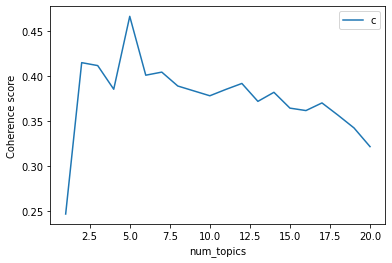

CPU times: user 1min 22s, sys: 6.07 s, total: 1min 28s
Wall time: 1min 18s


In [26]:
%%time
lmlist_lsi, c_v = evaluate_graph(dictionary=dictionary, corpus=corpus, texts=df_news['titleandbody'].apply(literal_eval), limit=21, model= "lsi")


---

Según la coherencia el mejor número de tópicos es 5. Seleccionaremos el número de tópicos realizando una inspección visual de la coherencia.

---

In [28]:
display_topics(lmlist_lsi[5])

Topic 0:
tambien tiempo vez momento comentarios parte equipo dia cuarentena abril 

Topic 1:
equipo futbol jugadores abril jugador club actividades empresas cosas medidas 

Topic 2:
comentarios clic problemas mail favor cuenta notas actividades cuarentena presidente 



---

#Latent Dirichlet Allocation Model

---

In [0]:
ldamodel = LdaModel(corpus=corpus, num_topics=10, id2word=dictionary)

In [30]:
display_topics(ldamodel)

Topic 0:
tambien presidente momento parte equipo tiempo cuarentena pandemia actividades horas 

Topic 1:
forma tambien parte casa tiempo horas trabajo pandemia aislamiento cuarentena 

Topic 2:
equipo tambien tiempo futbol vez parte vida momento dia veces 

Topic 3:
mundo enfermedad casa tambien salud tiempo familia dia sistema equipo 

Topic 4:
comentarios tambien momento cuenta tiempo problemas clic parte uso seguridad 

Topic 5:
ciudad parte tambien vez abril marzo sistema empresas gente forma 

Topic 6:
sistema tambien pandemia jugadores parte momento comentarios marzo tiempo medidas 

Topic 7:
oferta crisis tiempo empresas vez semana bonos gente abril momento 

Topic 8:
abril caso medidas uso tambien contacto forma comentarios contactos partir 

Topic 9:
vez beneficiarios cuarentena tambien ingreso forma mensajes tarjeta abril emergencia 



---

Se intenta hallar el número óptimo de tópicos para este modelo basado en la métrica coherencia.

---

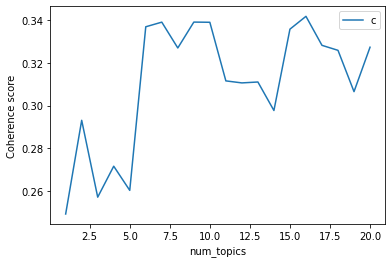

CPU times: user 2min 12s, sys: 75.9 ms, total: 2min 12s
Wall time: 2min 12s


In [31]:
%%time
lmlist, c_v = evaluate_graph(dictionary=dictionary, corpus=corpus, texts=df_news['titleandbody'].apply(literal_eval), limit=21, model= "lda")


---

Para este modelo el número óptimo de tópicos se ubica en 7. 

---

---

#Evaluación de la coherencia de los mejores modelos

Se elige una instancia de cada modelo teniendo en cuenta la métrica de coherencia. 

Se compara luego la coherencia entre ellos.

---

In [0]:
ldamodel = lmlist[7]
lsimodel = lmlist_lsi[5]

lsitopics = [[word for word, prob in topic] for topicid, topic in lsimodel.show_topics(formatted=False)]

hdptopics = [[word for word, prob in topic] for topicid, topic in hdpmodel.show_topics(formatted=False)]

ldatopics = [[word for word, prob in topic] for topicid, topic in ldamodel.show_topics(formatted=False)]

In [0]:
lsi_coherence = CoherenceModel(topics=lsitopics[:10], texts=df_news['titleandbody'].apply(literal_eval), dictionary=dictionary, window_size=10).get_coherence()

hdp_coherence = CoherenceModel(topics=hdptopics[:10], texts=df_news['titleandbody'].apply(literal_eval), dictionary=dictionary, window_size=10).get_coherence()

lda_coherence = CoherenceModel(topics=ldatopics, texts=df_news['titleandbody'].apply(literal_eval), dictionary=dictionary, window_size=10).get_coherence()

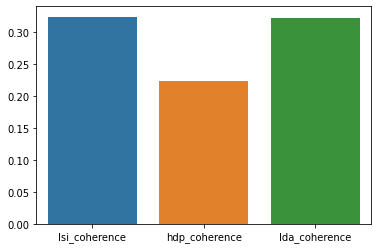

In [35]:
import seaborn as sns

coherences = [lsi_coherence, hdp_coherence, lda_coherence]
n = len(coherences)
x = ['lsi_coherence','hdp_coherence', 'lda_coherence']
sns.barplot(x, coherences)

Se observa en la gráfica que el modelo LDA con 12 tópicos tiene el mayor nivel de coherencia.

---


Se examinan las palabras clave de los tópicos del mejor modelo

---

In [36]:
display_topics(ldamodel)

Topic 0:
abril parte tambien comentarios marzo precios mercado cuenta aislamiento pago 

Topic 1:
futbol tambien comentarios equipo momento tiempo jugadores horas noticias dia 

Topic 2:
tambien abril emergencia empresas crisis parte marzo caso ingreso trabajadores 

Topic 3:
semana dia casa aislamiento momento horas empresas abril grupo forma 

Topic 4:
vez tiempo equipo casa tambien jugador jugadores momento cosas club 

Topic 5:
pandemia presidente cuarentena medidas autoridades horas aplicaciones parte ciudad aislamiento 

Topic 6:
tambien comentarios sistema forma tiempo mundo momento parte vez pacientes 

Topic 7:
oferta bonos vez tambien parte caso puntos equipo propuesta medidas 




---

#Clasificación de las noticias

---



---

Se seleccionó como modelo que mejor se adapta LDA y como número óptimo de tópicos 12.

Se asigna un tópico a cada noticia, es decir, se agrupan las noticias según los tópicos.

---

In [0]:
def format_topics_sentences(ldamodel=0, corpus=corpus, texts=0):
    # Init output
    sent_topics_df = pd.DataFrame()-n

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel, corpus=corpus, texts=df_news['titleandbody'].apply(literal_eval))

In [38]:
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.5971,"futbol, tambien, comentarios, equipo, momento,...","[estadio, futbol, quedarnos, casa, departament..."
1,1,1.0,0.5503,"futbol, tambien, comentarios, equipo, momento,...","[empresa, jugadores, opositores, temporada, eq..."
2,2,6.0,0.5819,"tambien, comentarios, sistema, forma, tiempo, ...","[cara, deportistas, rol, lucha, caso, campeona..."
3,3,1.0,0.9717,"futbol, tambien, comentarios, equipo, momento,...","[futbol, futbol, resto, actividades, marco, cr..."
4,4,4.0,0.6569,"vez, tiempo, equipo, casa, tambien, jugador, j...","[minuto, dilema, pagos, mundo, mote, facilidad..."
5,5,1.0,0.6709,"futbol, tambien, comentarios, equipo, momento,...","[boca, boca, semestre, debut, lesiones, regres..."
6,6,1.0,0.6190,"futbol, tambien, comentarios, equipo, momento,...","[boca, sumo, competidor, contrato, diciembre, ..."
7,7,1.0,0.9854,"futbol, tambien, comentarios, equipo, momento,...","[futuro, argentino, rumores, salida, futuro, f..."
8,8,1.0,0.9937,"futbol, tambien, comentarios, equipo, momento,...","[boca, vez, clubes, hockey, dia, clubes, boca,..."
9,9,1.0,0.9765,"futbol, tambien, comentarios, equipo, momento,...","[presidente, llevarse, jugadores, conflicto, c..."


---

Se mapea cada tópico con una etiqueta que lo describe.

Primero se crea el diccionario.

---

In [0]:
#label_dicc = {0:'trials', 1:'nature', 2:'violence', 3: 'protest', 4:'life_family', 5:'sea_disasters', 6:'elections', 7:'terrorism', 8:'economic_crisis', 9: 'seism', 10:'peacy_treaty', 11:'airport_security'}
#label_dicc = {0:'elecciones', 1:'espectáculos', 2:'chile', 3: 'familia', 4:'deportes y ocio', 5:'tecnología', 6:'economía', 7:'estudio', 8:'jóvenes', 9: 'deportes y videojuegos', 10:'justicia', 11:'ciudad'}

label_dicc = {0:'Mercado', 1:'Futbol', 2:'Crisis economica', 3: 'Aislamiento', 4:'Deporte', 5:'Medidas', 6:'Mundo', 7:'Deuda'}


In [0]:
df_dominant_topic['Dominant_Topic'] = df_dominant_topic['Dominant_Topic'].astype('int64')

---

Luego se realiza el mapeo.

---

In [41]:
df_dominant_topic['Dominant_Topic'] = df_dominant_topic['Dominant_Topic'].map(label_dicc)
df_dominant_topic.head(30)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,Futbol,0.5971,"futbol, tambien, comentarios, equipo, momento,...","[estadio, futbol, quedarnos, casa, departament..."
1,1,Futbol,0.5503,"futbol, tambien, comentarios, equipo, momento,...","[empresa, jugadores, opositores, temporada, eq..."
2,2,Mundo,0.5819,"tambien, comentarios, sistema, forma, tiempo, ...","[cara, deportistas, rol, lucha, caso, campeona..."
3,3,Futbol,0.9717,"futbol, tambien, comentarios, equipo, momento,...","[futbol, futbol, resto, actividades, marco, cr..."
4,4,Deporte,0.6569,"vez, tiempo, equipo, casa, tambien, jugador, j...","[minuto, dilema, pagos, mundo, mote, facilidad..."
5,5,Futbol,0.6709,"futbol, tambien, comentarios, equipo, momento,...","[boca, boca, semestre, debut, lesiones, regres..."
6,6,Futbol,0.6190,"futbol, tambien, comentarios, equipo, momento,...","[boca, sumo, competidor, contrato, diciembre, ..."
7,7,Futbol,0.9854,"futbol, tambien, comentarios, equipo, momento,...","[futuro, argentino, rumores, salida, futuro, f..."
8,8,Futbol,0.9937,"futbol, tambien, comentarios, equipo, momento,...","[boca, vez, clubes, hockey, dia, clubes, boca,..."
9,9,Futbol,0.9765,"futbol, tambien, comentarios, equipo, momento,...","[presidente, llevarse, jugadores, conflicto, c..."


In [0]:
df_news['Tópicos'] = df_dominant_topic['Dominant_Topic']

---

Se visualizan algunas noticias y su tópico asociado.

---

In [43]:
df_news[['titleandbody2', 'Tópicos']].head(30)
#df_news[['titleandbody2', 'Tópicos']][df_news['Tópicos']=='deportes'].head(50)

,titleandbody2,Tópicos
0,El “Pablo Vico” de España: tiene 83 años y pas...,Futbol
1,Adelantan que en Barcelona se habrían pagado s...,Futbol
2,"Jana Pittman, la campeona mundial que lucha en...",Mundo
3,Coronavirus: la OMS pidió que paren el fútbol ...,Futbol
4,"El Araña Amuchástegui, el crack que rechazó un...",Deporte
5,Daniele De Rossi: la gran anécdota de su prime...,Futbol
6,A Boca se le sumó un fuerte competidor: Lugano...,Futbol
7,Javier Zanetti volvió a ser tajante con el fut...,Futbol
8,Boca se suma y cada vez son más los clubes de ...,Futbol
9,El presidente de Santos acusó a Sampaoli de qu...,Futbol


In [0]:
# df_news[ df_news['Tópicos'] == 'deportes y ocio'].head().titleandbody2[29]

'Mario Ledesma, íntimo: el visceral DT de Los Pumas que llora, le teme a las alturas, come sin fondo y ama el campo // “No me hagas mirar hacia abajo porque me da vértigo”. Desde el piso 16 del hotel New Otani, frente al amplio ventanal de un cómodo salón, el pedido del protagonista al fotógrafo de Clarín suena casi a ruego. Y así lo justifica: “No me gustan las alturas porque me mareo. Quizá por eso no me gusta viajar en avión. En auto, tren o colectivo no tengo problemas. Si hasta en el tren bala pude escribir con el celular o leer sin problemas. Pero acá arriba...”. Quien habla es Mario Ezequiel Ledesma Arocena, “Bocha” para sus amigos (“No me acuerdo quién me puso ese apodo. Fue en Los Pumas y fue por el tamaño de mi cabeza y porque me empecé a quedar pelado de muy joven. Creo que en el Mundial 99 ya era pelado”, cuenta y recuerda), “Gordo” o “Negro” para su padre, quien así lo llamaba de chico y junto a su mamá\xa0les inculcó el amor y la pasión por el deporte\xa0a sus hermanos y 

---

Se visualiza la distribución de tópicos

---

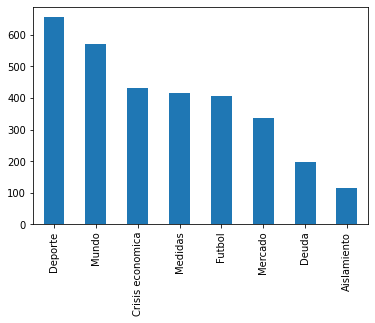

In [44]:
ax = df_dominant_topic['Dominant_Topic'].value_counts().plot(kind='bar')
plt.show()

Los tópicos están desbalanceados. En un trabajo futuro se avanzará sobre este problema.

---

#Visualización Interactiva del modelo

---

A partir del modelo configurado se realiza una visualización interactiva de los tópicos y las palabras claves que los representan. 

---

In [45]:
!pip install pyLDAvis

     |████████████████████████████████| 1.6MB 2.8MB/s 
     |████████████████████████████████| 552kB 47.1MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97711 sha256=f07571f9a31a41638f4297654bcfe954fadf0c8777df485911e32108487b5cd1
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
  Created wheel for funcy: filename=funcy-1.14-py2.py3-none-any.whl size=32042 sha256=7ce71e3586c9108636bded626c14f60207fe6b8300cd29863a6e42f0101befb0
  Stored in directory: /root/.cache/pip/wheels/20/5a/d8/1d875df03deae6f178dfdf70238cca33f948ef8a6f5209f2eb
Successfully built pyLDAvis funcy


In [0]:
import pyLDAvis

pyLDAvis.enable_notebook()

In [47]:
# %%time
import pyLDAvis.gensim
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.078751 -0.008969       1        1  20.139547
2     -0.026709  0.012728       2        1  17.080616
6     -0.005301 -0.027454       3        1  16.033926
5     -0.087207 -0.040503       4        1  12.963218
1      0.074513 -0.017896       5        1  11.576828
0     -0.028361  0.037718       6        1  10.497640
7     -0.003917  0.069713       7        1   6.476465
3     -0.001769 -0.025336       8        1   5.231762, topic_info=             Term         Freq        Total Category  logprob  loglift
447        oferta   528.000000   528.000000  Default  30.0000  30.0000
30         futbol   945.000000   945.000000  Default  29.0000  29.0000
12    comentarios  1303.000000  1303.000000  Default  28.0000  28.0000
386         abril  1550.000000  1550.000000  Default  27.0000  27.0000
1264        bonos   315.000000   315.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
68        tambien    88.324760  2516.322510   Topic8  -5.2058  -0.3991
51          parte    73.784927  1781.350830   Topic8  -5.3857  -0.2336
235        tiempo    72.449257  1932.041626   Topic8  -5.4040  -0.3330
164   actividades    58.048729   902.754700   Topic8  -5.6256   0.2063
278         veces    57.782524   802.701904   Topic8  -5.6302   0.3191

[701 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
7678      3  0.183274  abridores
7678      4  0.824732  abridores
386       1  0.108377      abril
386       2  0.265136      abril
386       3  0.081928      abril
...     ...       ...        ...
4050      5  0.017986       zoom
4050      6  0.526097       zoom
4050      7  0.044966       zoom
4050      8  0.004497       zoom
6248      4  0.738415   zoonosis

[2397 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 3, 7, 6, 2, 1, 8, 4])